In [38]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, AggOperations

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [239]:
board_id = BoardIds.CROWN_BOARD.value
params = BrainFlowInputParams()
params.mac_address = "C0:EE:40:84:DD:56"
params.serial_number = "58a99b0107e64cd40ea5e6607882cbe2"
params.board_id = board_id
params.timeout = 5
BoardShim.enable_dev_board_logger()
board = BoardShim(board_id, params)
board.prepare_session()

[2023-01-12 13:19:41.745] [board_logger] [info] incoming json: {
    "board_id": 23,
    "file": "",
    "file_anc": "",
    "file_aux": "",
    "ip_address": "",
    "ip_address_anc": "",
    "ip_address_aux": "",
    "ip_port": 0,
    "ip_port_anc": 0,
    "ip_port_aux": 0,
    "ip_protocol": 0,
    "mac_address": "C0:EE:40:84:DD:56",
    "master_board": -100,
    "other_info": "",
    "serial_number": "58a99b0107e64cd40ea5e6607882cbe2",
    "serial_port": "",
    "timeout": 5
}
[2023-01-12 13:19:41.745] [board_logger] [trace] Board object created 23
[2023-01-12 13:19:41.745] [board_logger] [debug] Use IP port 9000


In [240]:
inputs = []
outputs = []
BoardShim.disable_board_logger()
board.start_stream()
for i in range(1):
    print("Think Nothing")
    time.sleep(1)
    board.get_board_data()
    time.sleep(10)
    nothing = board.get_board_data()[1:9]
    
    print("Think Left")
    time.sleep(1)
    board.get_board_data()
    time.sleep(10)
    left = board.get_board_data()[1:9]

    print("Think Right")
    time.sleep(1)
    board.get_board_data()
    time.sleep(10)
    right = board.get_board_data()[1:9]
    
    inputs.append(nothing)
    inputs.append(left)
    inputs.append(right)
    outputs.append(1)
    outputs.append(0)
    outputs.append(2)
board.stop_stream()

Think Nothing
Think Yes
Think No


In [241]:
dataset = np.array([inputs, outputs], dtype=object)
np.save("raw_data.npy", dataset)

In [252]:
dataset = np.load("raw_data_recent.npy", allow_pickle=True)

In [242]:
# def downsample(data, hz):
#     num_downsamples = int(math.log2(256 / hz))
#     for i in range(1, num_downsamples + 1):
#         data += np.roll(data, i, axis=2)
#     data = (data / num_downsamples)[:,:,num_downsamples::num_downsamples]
#     return data

# def downsample(data, hz):
#     # HZ should be a full number
#     length = data.shape[1]
#     excess = length % (256 / hz)
    
#     # Cut off excess data
#     if excess != 0:
#         data = data[:,excess:]
#     length = data.shape[1]
    
#     length = data.shape[1]
#     split = np.split(data, length // hz, axis=1)
#     data = np.array([np.mean(section) for section in split]).flatten()
#     return data

def downsample(data, hz, channels=True):
    if channels:
        original_type = data.dtype
        data = data.astype('float64')
        
        for i, channel in enumerate(data):
            data[i] = DataFilter.perform_downsampling(data, int(256 / hz), AggOperations.MEAN.value)
        
        return data.astype(original_type)
    
    original_type = data.dtype
    data = data.astype('float64')
    return DataFilter.perform_downsampling(data, int(256 / hz), AggOperations.MEAN.value).astype(original_type)

In [253]:
inputs = []
targets = []
for i, data in enumerate(dataset[0]):
    # data = np.mean(data, axis=0)
    
    delta = downsample(data, 2)
    theta = downsample(data, 5)
    alpha_low = downsample(data, 8)
    alpha_high = downsample(data, 11)
    beta_low = downsample(data, 15)
    beta_high = downsample(data, 24)
    gamma_low = downsample(data, 35)
    gamma_mid = downsample(data, 45)
    gamma_high = downsample(data, 55)
    
    # Add to inputs and outputs
    for j in range(len(delta)):
        # Raw Samples Passed
        rsp = j * 2
        brain_waves = np.array([delta[:][j], theta[:][rsp//5], alpha_low[:][rsp//8], alpha_high[:][rsp//11], beta_low[:][rsp//15], beta_high[:][rsp//24], gamma_low[:][rsp//35], gamma_mid[:][rsp//45], gamma_high[:][rsp//55]]).flatten()
        
        inputs.append(brain_waves)
        targets.append(dataset[1][i])

targets = np.array(targets)
inputs = np.array(inputs)

In [254]:
print(inputs.shape)
print(targets.shape)

(179, 9)
(179,)


In [256]:
inputs_train, inputs_valid, targets_train, targets_valid = train_test_split(inputs, targets, test_size=0.3, random_state=50)

inputs_train = inputs_train.reshape(inputs_train.shape[0], -1)
inputs_valid = inputs_valid.reshape(inputs_valid.shape[0], -1)

model = tree.DecisionTreeClassifier(min_samples_leaf=10)
model = model.fit(inputs_train, targets_train)

In [257]:
plt.style.use('seaborn-v0_8-white')

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
1.0


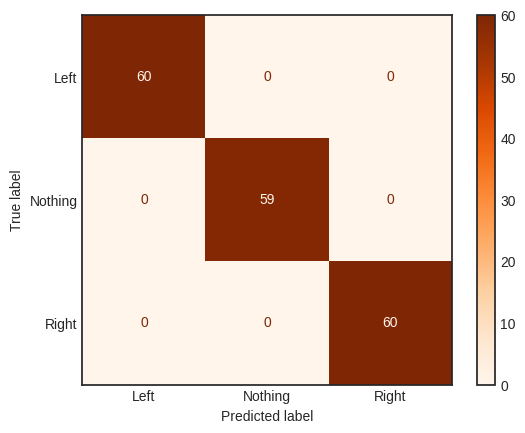

In [233]:
predictions = model.predict(inputs)

print(predictions)

accuracy = metrics.accuracy_score(targets, model.predict(inputs))
print(accuracy)

cm = metrics.confusion_matrix(targets, model.predict(inputs))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Nothing', 'Right'])
disp.plot(cmap=plt.cm.Oranges)
plt.show()

[2 0 0 0 0 0 0 0 0 1 1 1 2 1 0 1 0 0 2 2 0 2 2 0 0 1 2 0 0 1 2 2 1 2 0 1 1
 2 1 0 1 1 0 1 0 2 1 1 2 2 1 1 2 1]
1.0


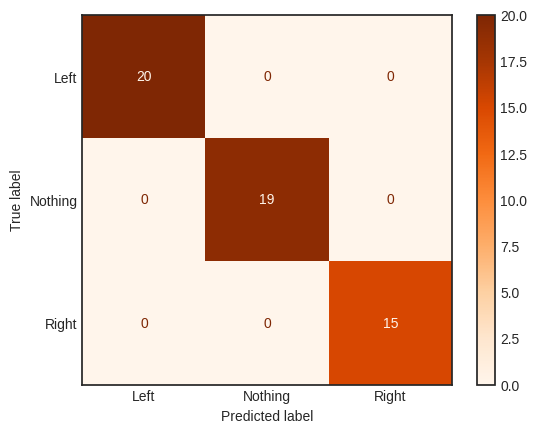

In [258]:
predictions = model.predict(inputs_valid)

print(predictions)

accuracy = metrics.accuracy_score(targets_valid, model.predict(inputs_valid))
print(accuracy)

cm = metrics.confusion_matrix(targets_valid, model.predict(inputs_valid))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Nothing', 'Right'])
disp.plot(cmap=plt.cm.Oranges)
plt.show()

[Text(0.5, 0.9166666666666666, 'X[7] <= -1631.674\ngini = 0.666\nsamples = 125\nvalue = [40, 40, 45]'),
 Text(0.3333333333333333, 0.75, 'X[7] <= -2374.326\ngini = 0.625\nsamples = 96\nvalue = [40, 40, 16]'),
 Text(0.16666666666666666, 0.5833333333333334, 'gini = 0.0\nsamples = 15\nvalue = [0, 15, 0]'),
 Text(0.5, 0.5833333333333334, 'X[7] <= -1994.591\ngini = 0.622\nsamples = 81\nvalue = [40, 25, 16]'),
 Text(0.3333333333333333, 0.4166666666666667, 'gini = 0.0\nsamples = 27\nvalue = [27, 0, 0]'),
 Text(0.6666666666666666, 0.4166666666666667, 'X[1] <= -1961.768\ngini = 0.64\nsamples = 54\nvalue = [13, 25, 16]'),
 Text(0.5, 0.25, 'X[1] <= -2020.304\ngini = 0.495\nsamples = 29\nvalue = [13, 0, 16]'),
 Text(0.3333333333333333, 0.08333333333333333, 'gini = 0.0\nsamples = 13\nvalue = [13, 0, 0]'),
 Text(0.6666666666666666, 0.08333333333333333, 'gini = 0.0\nsamples = 16\nvalue = [0, 0, 16]'),
 Text(0.8333333333333334, 0.25, 'gini = 0.0\nsamples = 25\nvalue = [0, 25, 0]'),
 Text(0.666666666666

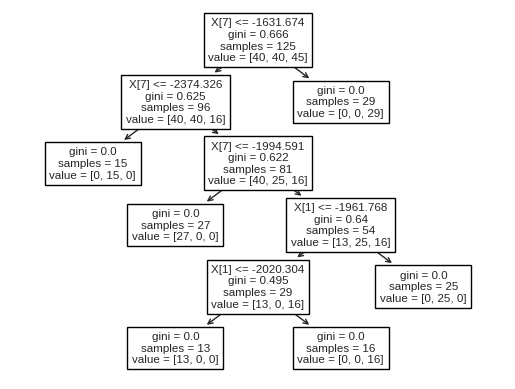

In [259]:
tree.plot_tree(model)

In [261]:
board.stop_stream()

In [262]:
board.start_stream()
BoardShim.disable_board_logger()

sample_size = 512
start_time = time.time()
last_read = start_time
time.sleep(3)

realtime_raw_data = board.get_board_data()[1:9]

while start_time + 30 > time.time():
    realtime_raw_data = np.concatenate((realtime_raw_data, board.get_board_data()[1:9]), axis=1)[:,-sample_size:]
    
    realtime_data = np.mean(realtime_raw_data, axis=0)
    
    sr = 256
    
    delta = downsample(realtime_data, 2)[-1]
    theta = downsample(realtime_data, 5)[-1]
    alpha_low = downsample(realtime_data, 8)[-1]
    alpha_high = downsample(realtime_data, 11)[-1]
    beta_low = downsample(realtime_data, 15)[-1]
    beta_high = downsample(realtime_data, 24)[-1]
    gamma_low = downsample(realtime_data, 35)[-1]
    gamma_mid = downsample(realtime_data, 45)[-1]
    gamma_high = downsample(realtime_data, 55)[-1]
    
    
    if time.time() > last_read + 0.5:
        predictions = model.predict(np.array([delta, theta, alpha_low, alpha_high, beta_low, beta_high, gamma_low, gamma_mid, gamma_high]).reshape(1, -1))
        last_read = time.time()
        print(['Left', 'Nothing', 'Right'][predictions[0]])
    
    time.sleep(0.1)

board.stop_stream()

Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right
Right


KeyboardInterrupt: 

In [237]:
board.release_session()